# Template code for CNN

In this notebook, we will show a simple usage of CNN on the MNIST dataset. 
The usage of GPUs is highly recommended

In [1]:
#!pip install torch==2.4 # Run just once
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from math import floor

# Set torch seed


## Dataset
First, we load the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) directly from PyTorch. As usual, we split data within train, evaluation and test. Then, we create the `Dataloader` object

In [2]:
dataset_train = datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor()) # download = True just once
dataset_test = datasets.MNIST('.', train=False, download=True, transform=transforms.ToTensor())

dataset_validation, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])
print("We have", len(dataset_validation), "items for validation and", len(dataset_test), "items for test")

batch_size = 64 # Reduce it in case you need it

train_loader = DataLoader(dataset_train, batch_size=batch_size)
validation_loader = DataLoader(dataset_validation, batch_size=len(dataset_validation))
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1147)>



100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1147)>



100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1147)>



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1147)>



100.0%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

We have 5000 items for validation and 5000 items for test


## Model

Define a simple Convolutional neural network having 3 conv + pool layers. As activation function, use ReLu

In [30]:
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out
    
    
class CNN(nn.Module):
    def __init__(self): # build the network structure
        super(CNN, self).__init__()
        # first convolutional layer
        # just 1 input channel because black/white images
        # 32 output channel because the filter applyed are 32 -> it is not my responsability which filters, I just decide the number of them
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        h_out, w_out = out_dimensions(self.conv1, 28, 28)
        # second conv layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        # pooling layer (max)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        # fully connected layer
        self.fc1 = nn.Linear(32 * h_out * w_out, 10)
        self.dimensions_final = (32, h_out, w_out)

    def forward(self, x): # define how the forward propagation works
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w) # tensor output of pooling layer is flattened (-1)
        x = self.fc1(x)
        return x

## Training

In [31]:
model = CNN()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on mps


In [33]:
n_epochs = 3
train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    loss_train = 0
    for data, target in train_loader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    loss_train = loss_train / len(train_loader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validation_loader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
    

Epoch 1: Train loss: 0.1388174099598213, Validation loss 0.07702840119600296
Epoch 2: Train loss: 0.052359154047999235, Validation loss 0.05540435016155243
Epoch 3: Train loss: 0.03446634875380464, Validation loss 0.0630265474319458


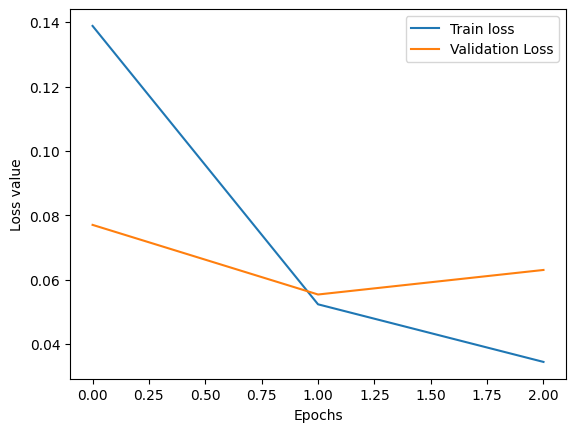

In [34]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

## Test

In this section, we test our model on new data by computing the accuracy

In [35]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 98.26 %
